# Welcome

In [1]:
import new_experiment_runner.feature_extractors_config as fe
import tensorflow as tf

import os
from collections import deque
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

## Set Hyperparameters

In [2]:
SEQ_LEN = 50
FEAT_EXTRACTOR = fe.MobileNetV2Extractor()

In [3]:
dir_path = '.\saved_experiments'
dir_list = list(os.walk(dir_path))[0][1]
model_names = dict(map(lambda x: (x, list(os.walk(dir_path+'/'+x))[0][1]), dir_list))
global model
model = None

def select_model(model):
    print(os.path.join(dir_path, exp_w.value, model))
    return os.path.abspath(os.path.join(dir_path, exp_w.value, model))

def select_experiment(experiment):
    if 'logs' in model_names[experiment]: model_names[experiment].remove('logs')
    model_w.options = model_names[experiment]

def load_model(b):
    global model
    model = tf.saved_model.load(model_w_i.result)

exp_w = widgets.Dropdown(options=model_names.keys())
model_w = widgets.Select(options=model_names[exp_w.value])
model_w_i = widgets.interactive(select_model, model=model_w)
exp_w_i = widgets.interactive(select_experiment, experiment=exp_w)

button = widgets.Button(description="Load Model")
button.on_click(load_model)

display(exp_w_i)
display(model_w_i)
display(button)

interactive(children=(Dropdown(description='experiment', options=('mobilenet_experiments_1',), value='mobilene…

interactive(children=(Select(description='model', options=('gru', 'lstm'), value='gru'), Output()), _dom_class…

Button(description='Load Model', style=ButtonStyle())

## Run

In [4]:
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the fa- prefix)
)
def view(button):
    cap = cv2.VideoCapture(0)

    display_handle=display(None, display_id=True)
    frame_queue = deque(maxlen=SEQ_LEN)

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = .5
    fontColor              = (0, 0,255)
    thickness              = 1
    lineType               = 2
    CLASS_LIST=['JumpingJack', 'PushUp', 'BodyWeightSquats']
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        height, width, channels = frame.shape

        # extract features and add to frame queue
        frame_features = FEAT_EXTRACTOR.live_extract(frame)
        frame_queue.append(tf.keras.layers.Flatten()(frame_features))
        if len(frame_queue)<SEQ_LEN:
            print('Queueing frame:', len(frame_queue), end='\r')
            continue
        x = tf.convert_to_tensor(list(frame_queue))
        x = tf.transpose(x, perm=[1, 0, 2])

        if len(frame_queue) == SEQ_LEN:
            predicted_label_probabilities = model(x)[0]
            predicted_label = np.argmax(predicted_label_probabilities)
            predicted_class = CLASS_LIST[predicted_label]
        
        for idx, (pred, label) in enumerate(zip(predicted_label_probabilities.numpy(), CLASS_LIST)):
            cv2.putText(frame, label+': '+'{:f}'.format(pred) , (10, 30*(idx+1)), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 255 if idx==predicted_label else 0, 255), 2)

        ret, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
        
        if stopButton.value:
            cap.release()
            out.release()
            display_handle.update(None)
            cv2.destroyAllWindows()
            break

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

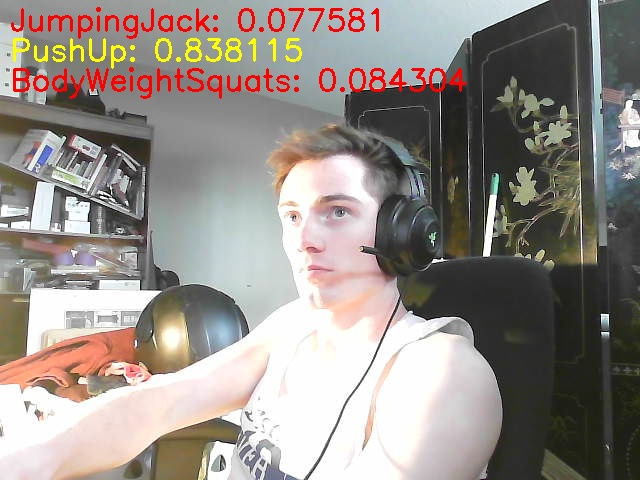

In [5]:
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()